In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.models as models
import torchvision

from tqdm import tqdm

from diffusers import DDPMScheduler, UNet2DConditionModel, UNet2DModel
from clip import clip
from autoencoder import ResNet_AutoEncoder

import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
channels = [64,128,256,256]
num_of_blocks = 2
down_sample = [True,True,False]
autoencoder = ResNet_AutoEncoder(channels,num_of_blocks,down_sample).to(device)
autoencoder.load_state_dict(torch.load("parameters/autoencoder.pth", weights_only=True))
print(f"Model parameter count: {sum(p.numel() for p in autoencoder.parameters())/1e6:.2f}M")

Model parameter count: 9.81M


In [4]:
model = UNet2DConditionModel(
        sample_size=8,          
        in_channels=3,            
        out_channels=3,
        layers_per_block=2,
        block_out_channels=(128,128,256),
        cross_attention_dim = 512,
        down_block_types=( 
            "CrossAttnDownBlock2D",
            "AttnDownBlock2D",
            "DownBlock2D",
        ), 
        up_block_types=(
            "UpBlock2D",
            "AttnUpBlock2D",
            "CrossAttnUpBlock2D",
        ),
    ).to(device)
model.load_state_dict(torch.load("parameters/unet.pth", weights_only=True))
print(f"Model parameter count: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

Model parameter count: 21.21M


In [5]:
clip_model, preprocess = clip.load("ViT-B/32")
print(f"Model parameter count: {sum(p.numel() for p in clip_model.parameters())/1e6:.2f}M")

Model parameter count: 151.28M


In [6]:
mean = (0.5,0.5,0.5)
std = (0.5,0.5,0.5)
inverse_transform = transforms.Normalize(
    mean=[-m/s for m, s in zip(mean, std)], 
    std=[1/s for s in std]
)

In [7]:
data = torch.load("parameters/latent_stats.pt",weights_only=True)
channel_means = data["normalization_mean"]
channel_stds = data["normalization_std"]

In [8]:
latent_transform = transforms.Normalize(
    mean = channel_means,
    std = [3*std for std in channel_stds],
)
inverse_latent_transform = transforms.Normalize(
    mean=[-m/s for m, s in zip(channel_means,[3*std for std in channel_stds])], 
    std=[1/s for s in [3*std for std in channel_stds]]
)

In [28]:
prompt = "a photo of a horse"
num_samples = 16

4000it [02:11, 30.35it/s]


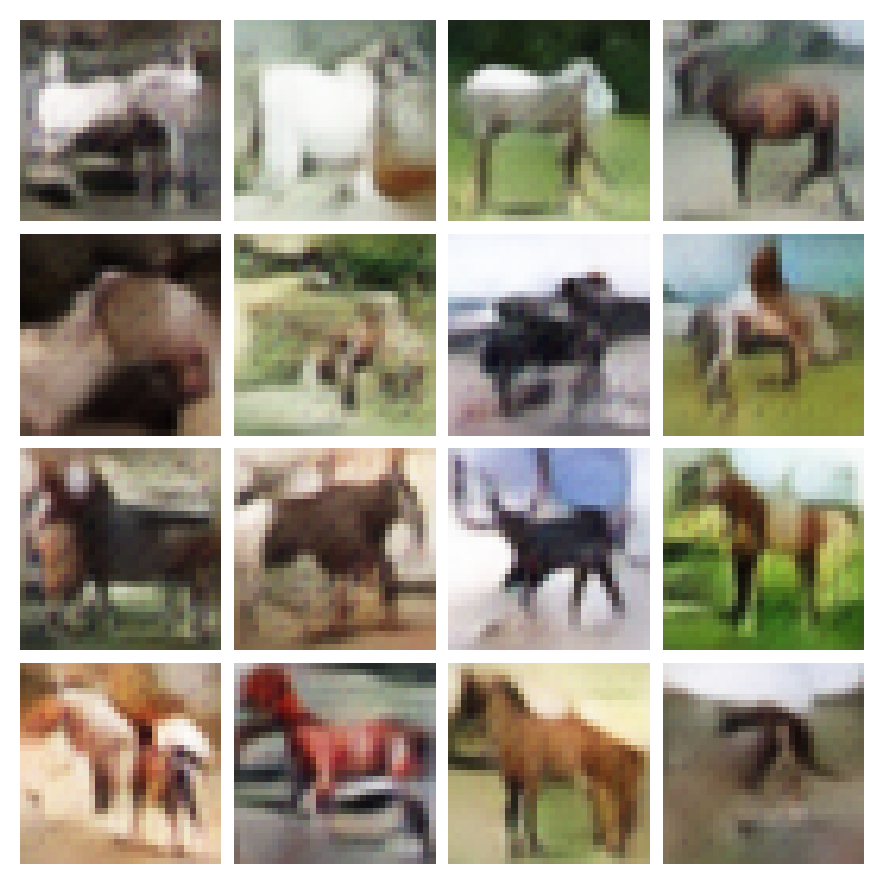

In [29]:
noise_scheduler = DDPMScheduler(num_train_timesteps=4000,prediction_type="epsilon")
sample = torch.randn(num_samples, 3, 8, 8).to(device)
text_token = clip.tokenize(prompt).to(device)
with torch.no_grad():
    text_embedding = clip_model.encode_text(text_token).to(torch.float32).repeat(num_samples,1).unsqueeze(1)
    for i,t in tqdm(enumerate(noise_scheduler.timesteps)):
        output = model(sample, t, text_embedding).sample
        sample = noise_scheduler.step(output, t, sample).prev_sample
unnormalized_latents = inverse_latent_transform(sample)
images = inverse_transform(autoencoder.decoder(unnormalized_latents))
grid = torchvision.utils.make_grid(images, nrow=4, padding=2, pad_value=1)

plt.figure(figsize=(16, 16))
plt.imshow(grid.permute(1,2,0).cpu(),cmap="gray")
plt.axis('off')
plt.show()

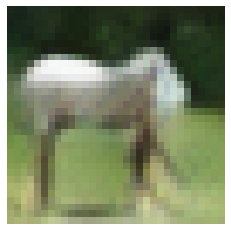

In [32]:
plt.imshow(images[2].permute(1,2,0).detach().cpu(),cmap="gray")
plt.axis('off')
plt.show()

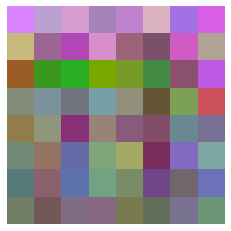

In [68]:
latent = sample[2]
latent = ((latent+1)*255/2).detach().cpu().long()
plt.imshow(latent.permute(1,2,0))
plt.axis('off')
plt.show()

In [11]:
def generate(prompt, num_samples = 16):
    noise_scheduler = DDPMScheduler(num_train_timesteps=4000,prediction_type="epsilon")
    sample = torch.randn(num_samples, 3, 8, 8).to(device)
    text_token = clip.tokenize(prompt).to(device)
    with torch.no_grad():
        text_embedding = clip_model.encode_text(text_token).to(torch.float32).repeat(num_samples,1).unsqueeze(1)
        for i,t in tqdm(enumerate(noise_scheduler.timesteps)):
            output = model(sample, t, text_embedding).sample
            sample = noise_scheduler.step(output, t, sample).prev_sample
            
    unnormalized_latents = inverse_latent_transform(sample)
    images = inverse_transform(autoencoder.decoder(unnormalized_latents))
    grid = torchvision.utils.make_grid(images, nrow=4, padding=2, pad_value=1)

    plt.figure(figsize=(16, 16))
    plt.imshow(grid.permute(1,2,0).cpu(),cmap="gray")
    plt.axis('off')
    plt.show()

4000it [01:55, 34.70it/s]


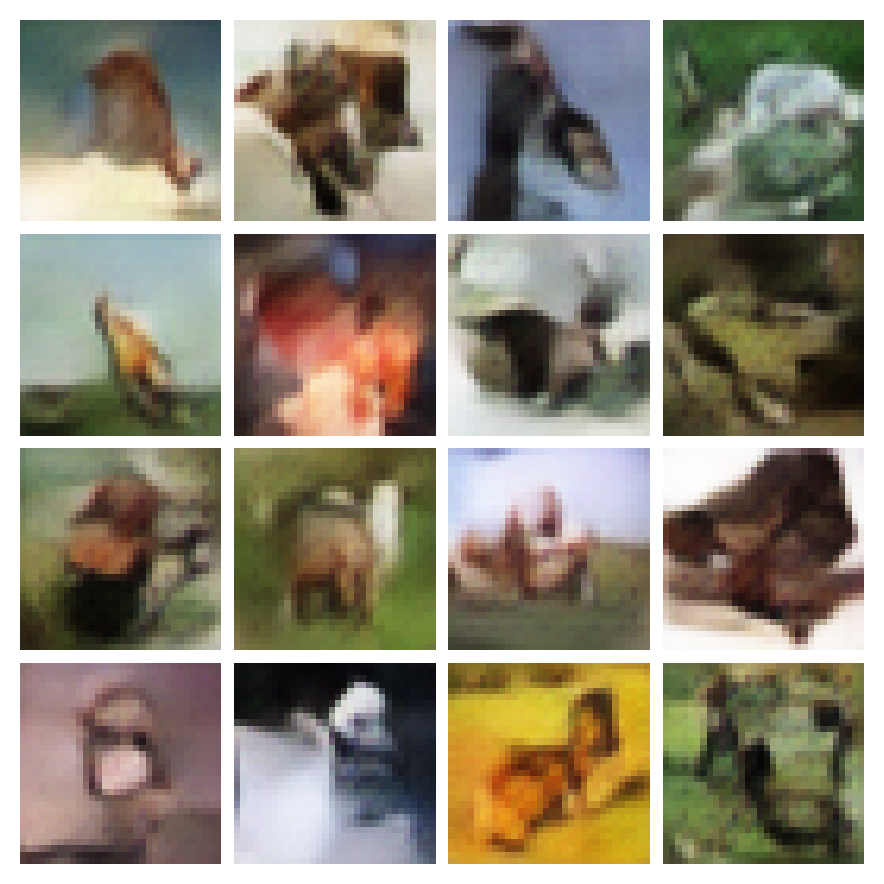

In [69]:
generate("a photo of an animal")

4000it [02:02, 32.68it/s]


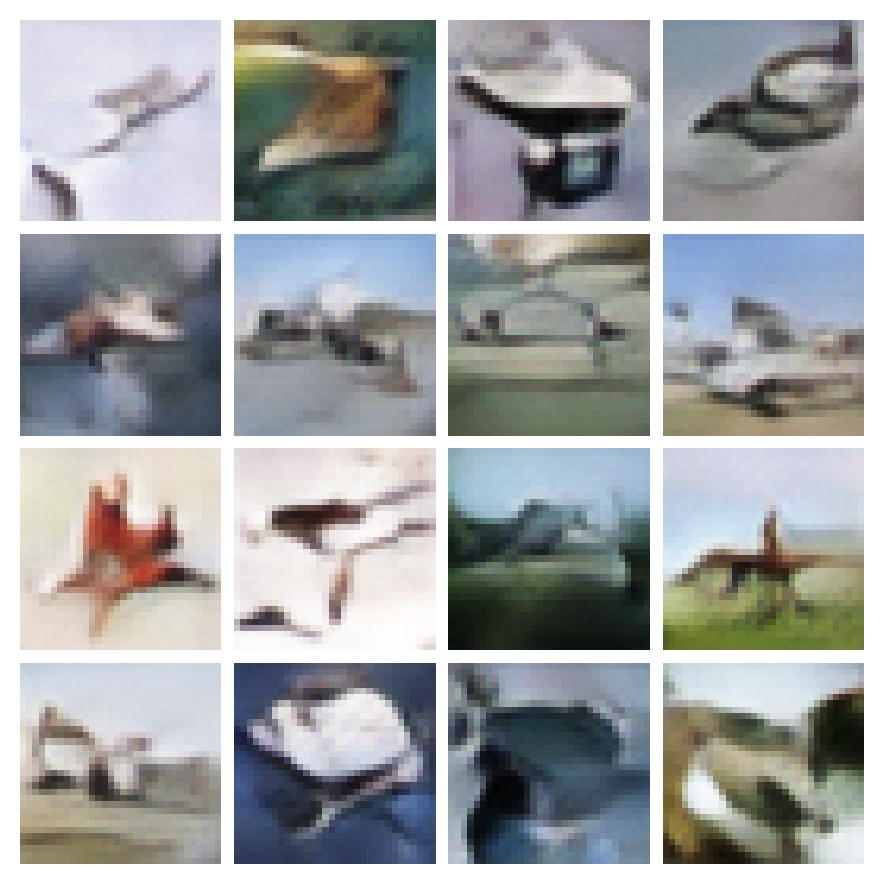

In [12]:
generate("a photo of a flying vehicle")

4000it [02:00, 33.19it/s]


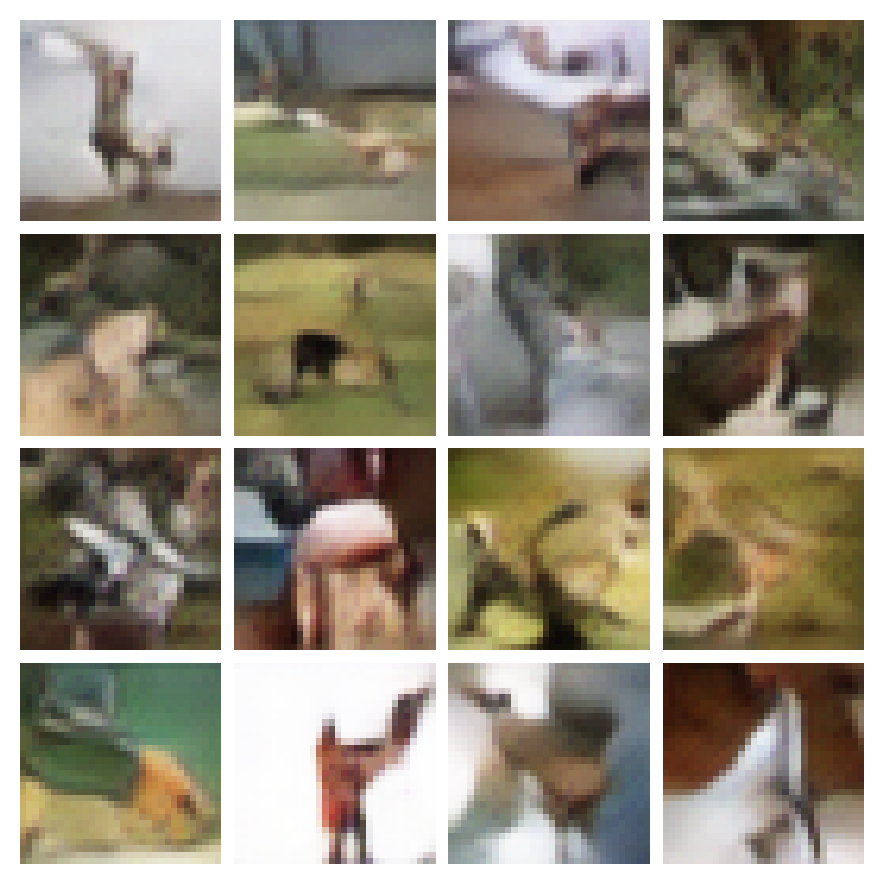

In [13]:
generate("a photo of a flying animal")

4000it [01:58, 33.85it/s]


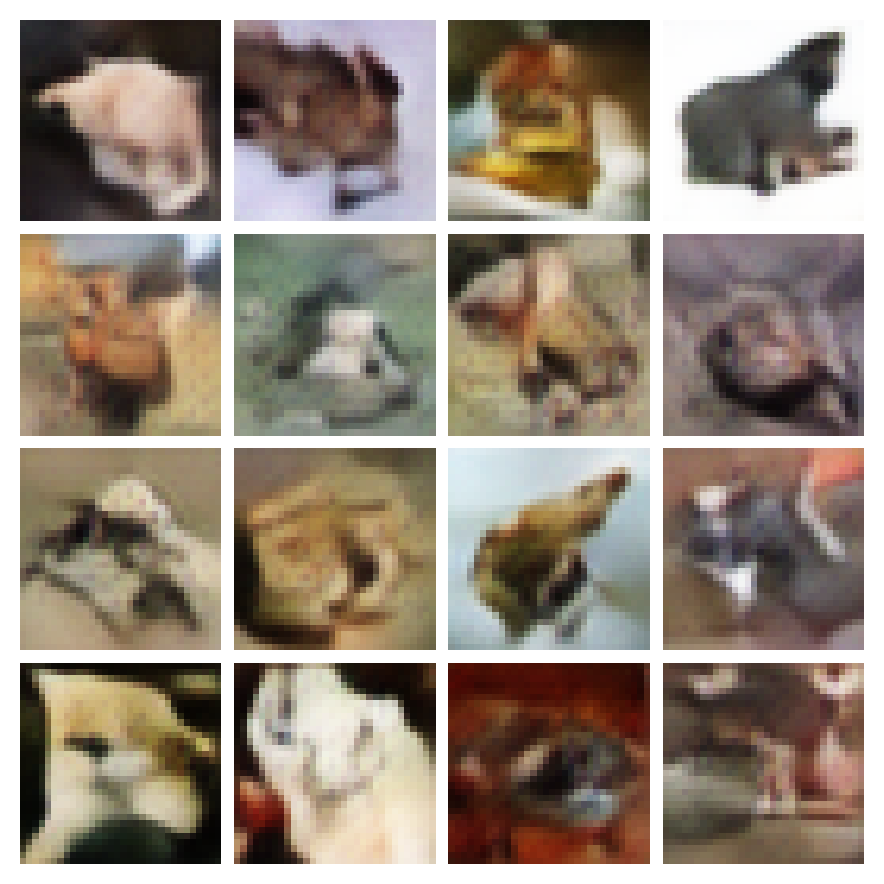

In [14]:
generate("a photo of a green small animal")

In [19]:
model

UNet2DConditionModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 128, eps=1e-06, affine=True)
          (proj_in): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=128, out_features=128, bias=False)
                (to_k): Linear(in_features=128, out_features=128, bias=False)
                (to_v): Linear(in_features=128, out_featu